In [1]:
import numpy as np
import pandas as pd
import re
import glob #this makes a list of all the files in a directory
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *

In [2]:
with_gender = pd.read_pickle("WithGenderFinal.p")
with_gender['gender'].value_counts()
line_column=[]
for i in with_gender.index:
        line_column.append(' '.join(with_gender['Speech'][i]))
with_gender['Line']=line_column

#how many words in line
length_column=[]
for i in with_gender.index:
        length_column.append(len(with_gender['Line'][i].split()))
with_gender['linelength']=length_column

with_gender_dum = pd.get_dummies(with_gender['gender'])
with_gender = pd.concat([with_gender, with_gender_dum],axis=1).drop(['F','gender'],1)

In [3]:
with_gender_sort = with_gender.sort_values(by=['Title','LineID'])
with_gender_sort = with_gender_sort.reset_index(drop=True)

In [4]:
#check if next record is also the next line in the script
#if so, record the gender of the next speaker (ToMale or ToFemale)
to_male_column=[]
to_female_column=[]
for i in with_gender_sort.index:
    if i+1 < len(with_gender_sort) and (with_gender_sort['LineID'][i]+1)==with_gender_sort['LineID'][i+1]:
        if with_gender_sort['Char'][i]!=with_gender_sort['Char'][i+1]:
            if with_gender_sort['M'][i+1]==1:
                to_male_column.append(1)
                to_female_column.append(0)
            if with_gender_sort['M'][i+1]==0:
                to_male_column.append(0)
                to_female_column.append(1)
        else:
            to_male_column.append(0)
            to_female_column.append(0)
    else:
        to_male_column.append(0)
        to_female_column.append(0)
with_gender_sort['ToMale']=to_male_column
with_gender_sort['ToFemale']=to_female_column

In [5]:
with_gender_sort.head(n=50)

Char Title   Genre           pkey  LineID  \
0        ALLEN    12  Comedy       allen-12       7   
1        ALLEN    12  Comedy       allen-12       9   
2        ALLEN    12  Comedy       allen-12      12   
3        ALLEN    12  Comedy       allen-12      14   
4        ALLEN    12  Comedy       allen-12      16   
5        ALLEN    12  Comedy       allen-12      18   
6        ALLEN    12  Comedy       allen-12      20   
7        ALLEN    12  Comedy       allen-12      22   
8        ALLEN    12  Comedy       allen-12      24   
9        ALLEN    12  Comedy       allen-12      26   
10       ALLEN    12  Comedy       allen-12      28   
11       ALLEN    12  Comedy       allen-12      30   
12       ALLEN    12  Comedy       allen-12      32   
13       ALLEN    12  Comedy       allen-12      34   
14       ALLEN    12  Comedy       allen-12      36   
15       ALLEN    12  Comedy       allen-12      38   
16       ALLEN    12  Comedy       allen-12      40   
17       ALLEN    12  Comedy       allen-12      41   
18       ALLEN    12  Comedy       allen-12      42   
19       ALLEN    12  Comedy       allen-12      44   
20       ALLEN    12  Comedy       allen-12      45   
21       ALLEN    12  Comedy       allen-12      47   
22       ALLEN    12  Comedy       allen-12      49   
23       ALLEN    12  Comedy       allen-12      50   
24       ALLEN    12  Comedy       allen-12      51   
25       ALLEN    12  Comedy       allen-12      53   
26       ALLEN    12  Comedy       allen-12      55   
27       ALLEN    12  Comedy       allen-12      57   
28       ALLEN    12  Comedy       allen-12      59   
29       ALLEN    12  Comedy       allen-12      61   
30       ALLEN    12  Comedy       allen-12      63   
31        TONY    12  Comedy        tony-12      66   
32  MARIE-NOEL    12  Comedy  marie-noel-12      67   
33        TONY    12  Comedy        tony-12      68   
34        TONY    12  Comedy        tony-12      70   
35  MARIE-NOEL    12  Comedy  marie-noel-12      71   
36        TONY    12  Comedy        tony-12      72   
37  MARIE-NOEL    12  Comedy  marie-noel-12      73   
38        TONY    12  Comedy        tony-12      75   
39  MARIE-NOEL    12  Comedy  marie-noel-12      76   
40        TONY    12  Comedy        tony-12      77   
41        TONY    12  Comedy        tony-12      78   
42        TONY    12  Comedy        tony-12      79   
43        TONY    12  Comedy        tony-12      80   
44  MARIE-NOEL    12  Comedy  marie-noel-12      81   
45  MARIE-NOEL    12  Comedy  marie-noel-12      82   
46  MARIE-NOEL    12  Comedy  marie-noel-12      85   
47  MARIE-NOEL    12  Comedy  marie-noel-12      87   
48  MARIE-NOEL    12  Comedy  marie-noel-12      88   
49  MARIE-NOEL    12  Comedy  marie-noel-12      89   

                                               Speech  \
0   [Okay...hold on. Yeah I'll take care of, you i...   
1   [Hello.? Yeah okay I've got somebody else, on ...   
2                                  [Okay, oh doctor.]   
3                                    [Are you there?]   
4              [Can I use my real name on the radio?]   
5   [First of all I'm invisible. I see, myself loo...   
6   [And the next thing you know I'm, getting marr...   
7                       [Like an entire solid month.]   
8   [Then all of a sudden I see myself, walking do...   
9         [Can you hold on for one second..., Hello.]   
10  [Yeah, I've got two other lines., Can you hold...   
11  [Hello...yeah...hold on. I can, transfer you n...   
12                                   [Hi. Hi. Sorry.]   
13                                          [Sorry..]   
14                             [I'm really sorry....]   
15                                         [Am I on?]   
16  [Okay. I'm walking along the road down, by the...   
17  [... I ride around with people. I get, in thei...   
18                  [I mean here...this, this, this.]   
19  [Can you hold on a second?, - Glasses disappea...   
20  [I'

In [6]:
#tried removing short lines (didn't really work...not enough data)
with_gender_long=with_gender_sort[with_gender_sort['linelength']>10]

In [7]:
with_gender['M'].value_counts()

1    201934
0     84804
Name: M, dtype: int64

In [8]:
201934.0/(201934+84804)

0.7042456877009674

In [10]:
print np.mean(with_gender['linelength'])

11.68574099


In [11]:
with_gender_shuffle = shuffle(with_gender_sort, random_state = 5)

# Randomly split into training and dev with scikit-learn helper function
train, test = train_test_split(with_gender_shuffle, test_size=0.1, random_state=100)
#dev, test = train_test_split(test, test_size=0.5, random_state=200)

print train.shape
#print dev.shape
print test.shape
print test['M'].value_counts()

(258064, 11)
(28674, 11)
1    20153
0     8521
Name: M, dtype: int64


In [12]:
print "Most Common Class (Baseline) Dev Accuracy:", round(100*(20153.0/(20153+8521)),2)

Most Common Class (Baseline) Dev Accuracy: 70.28


In [13]:
train.head(n=2)

Char              Title    Genre                       pkey  LineID  \
8265      JACK     allthekingsmen    Drama        jack-allthekingsmen     716   
87408  CLIFTON  englishpatientthe  Romance  clifton-englishpatientthe      53   

                                                  Speech  \
8265                         [(shaking her), Answer me!]   
87408  [(beaming at Almasy), Isn't it?  Wedding prese...   

                                                    Line  linelength  M  \
8265                            (shaking her) Answer me!           4  1   
87408  (beaming at Almasy) Isn't it?  Wedding present...          18  1   

       ToMale  ToFemale  
8265        0         1  
87408       1         0

In [14]:
#train_y, dev_y, test_y = train.M, dev.M, test.M
train_y, test_y = train.M, test.M
train_X = train.drop(['M','Speech','LineID','pkey','linelength'],1)
#dev_X = dev.drop(['M','Speech','LineID','pkey','linelength'],1)
test_X = test.drop(['M','Speech','LineID','pkey','linelength'],1)
test_X.head()

Char                        Title    Genre  \
13071   GEORGES                        amour  Romance   
193640    PAULA            myweekwithmarilyn    Drama   
273222   WALTER                   visitorthe    Crime   
45675     ROMEO  boondocksaints2allsaintsday    Crime   
194304   FERRIS                         next   Sci-Fi   

                                                     Line  ToMale  ToFemale  
13071   I'll do that tomorrow morning. Anyway, they di...       0         0  
193640         But Marilyn is not ready. She's preparing.       0         0  
273222                                           Damn it!       0         0  
45675                                   Too sacrilegious.       0         0  
194304  That's why I need your people. Everybody else ...       1         0

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils
from keras.layers import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [16]:
NUM_WORDS=20000
from keras.preprocessing.text import Tokenizer
t=Tokenizer(num_words=NUM_WORDS, 
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', 
            lower=True)

t.fit_on_texts(train_X.Line.values)

x_train = t.texts_to_sequences(train_X.Line.values)
x_test = t.texts_to_sequences(test_X.Line.values)
#x_dev = t.texts_to_sequences(dev_X.Line.values)

In [17]:
print train_X.Line.values[1]
print x_train[1]

print train_X.Line.values[2]
print x_train[2]

print test_X.Line.values[1]
print x_test[1]

print test_X.Line.values[2]
print x_test[2]

(beaming at Almasy) Isn't it?  Wedding present from Katharine's parents.  I'm calling it Rupert Bear.  Hello.  Geoffrey Clifton.
[7840, 48, 7290, 206, 9, 7, 922, 1036, 70, 6288, 6, 697, 2, 20, 489, 7, 3466, 1200, 258, 10935, 8175]
Don't do that. It scares me.
[22, 9, 26, 10, 7, 4832, 15]
But Marilyn is not ready. She's preparing.
[35, 1689, 14, 31, 354, 46, 6, 5209]
Damn it!
[420, 7]


In [18]:
maxlen=100
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
#x_dev = sequence.pad_sequences(x_dev, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
#print('x_dev shape:', x_dev.shape)

Pad sequences (samples x time)
('x_train shape:', (258064, 100))
('x_test shape:', (28674, 100))


In [19]:
labels= train_y.values.reshape(-1,1)
#labels_dev=dev_y.values.reshape(-1,1)
labels_test = test_y.values.reshape(-1,1)
print('labels shape:', labels.shape)
print('labels_test shape:', labels_test.shape)
#print('labels_dev shape:', labels_dev.shape)

('labels shape:', (258064, 1))
('labels_test shape:', (28674, 1))


In [20]:
#to get the word embeddings run in terminal:
#wget -O 'PretrainedWord2Vec.bin.gz' "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#gunzip PretrainedWord2Vec.bin.gz

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('PretrainedWord2Vec.bin', binary=True)

In [21]:
word_index = t.word_index
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [22]:
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

cnn_model_best = Sequential()

#Uses pretrained word embeddings:
cnn_model_best.add(embedding_layer)

cnn_model_best.add(Dropout(0.25))

cnn_model_best.add(Conv1D(10, 5, 
                     padding='valid', 
                     activation='relu',
                     strides=1,
                     input_shape=train.shape))

cnn_model_best.add(GlobalMaxPooling1D())
cnn_model_best.add(Dropout(0.25))
cnn_model_best.add(Activation('relu'))
cnn_model_best.add(Dense(1))
          
cnn_model_best.add(Activation('sigmoid'))

cnn_model_best.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
cnn_model_best.fit(x_train, labels,
          batch_size=128,
          epochs=3,
          validation_data=(x_test, labels_test))

Train on 258064 samples, validate on 28674 samples
Epoch 1/3
258064/258064 [==============================] - 144s 557us/step - loss: 0.5993 - acc: 0.7040 - val_loss: 0.5804 - val_acc: 0.7092

In [27]:
cnn_model = Sequential()

#WITHOUT pretrained word embeddings:
cnn_model.add(Embedding(vocabulary_size,
                    EMBEDDING_DIM,
                    input_length=maxlen))

cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(10, 5, 
                     padding='valid', 
                     activation='relu',
                     strides=1,
                     input_shape=train.shape))

cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.25))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(1))
          
cnn_model.add(Activation('sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
cnn_model.fit(x_train, labels,
          batch_size=128,
          epochs=3,
          validation_data=(x_test, labels_test))

Train on 258064 samples, validate on 28674 samples
Epoch 1/3
258064/258064 [==============================] - 141s 547us/step - loss: 0.5925 - acc: 0.7066 - val_loss: 0.5766 - val_acc: 0.7136

In [28]:
score = cnn_model_best.evaluate(x_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.57285561577465738)
('Test accuracy:', 0.71678175350491735)


In [29]:
predictions = cnn_model_best.predict_classes(x_test, batch_size=1000)

28674/28674 [==============================] - 3s 91us/step

In [30]:
probabilities = cnn_model_best.predict(x_test, verbose=1)

28674/28674 [==============================] - 3s 108us/step

In [31]:
probabilities
print np.mean(probabilities)
print np.std(probabilities)

0.711955
0.138681


In [32]:
from sklearn.metrics import confusion_matrix

y_pred = probabilities > 0.5

confusion_matrix(labels_test, y_pred)

array([[ 1064,  7457],
       [  664, 19489]])

In [33]:
labels_test

array([[1],
       [0],
       [1],
       ..., 
       [0],
       [1],
       [0]], dtype=uint8)

In [34]:
binarized_pred = probabilities.round()

In [35]:
wrong_probs=[]
lengths_corr_fem=[]
print "Correctly Labeled as Female:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 0 and int(labels_test[i])==0:
            #print "correct call"
            print test_X.Char.values[i], ": ", test_X.Line.values[i], "\n"
            lengths_corr_fem.append(len(test_X.Line.values[i].split()))
    elif int(binarized_pred[i]) != int(labels_test[i]):
        #print "Incorrect prediction: called %s instead of %s, %3.4f sure" % (binarized_pred[i], labels_dev[i], probabilities[i])
        #print dev_X.Line.values[i]
        wrong_probs.append(probabilities[i])

print np.mean(wrong_probs)
print np.mean(lengths_corr_fem)

Correctly Labeled as Female:
ANNA :  Alexei!--you got away at last. Can you stay? 

MARIANNE :  But Edward loves you. 

VADA :  You don't have to wait, daddy'll be mad if you're late. 

GAIL :  (offscreen) Hey, Mickey! 

UGGA :  What? Grug! 

SAWSAN :  Sa'ad has disappeared. His wife, his children are missing. My uncle in Mansour. He said they were targeting them. They were killing them.. 

ELLA :  Mumble? 

JENNY :  And as brightly as the sun would shine when he was with me, every time he left it disappeared. I wanted to be as important to him as you were, and I was never going to be. I was make-believe and his other life, you, were real. 

ZOE :  Well, are they going to come out and tell me? And that's not even the point. He said, the babies weren't his. And if he says that, he thinks that. And if he thinks that, he's not really committed. 

ANNIE :  (Laughing) M'hm.  Yeah.  Yeah. 

NICOLE :  That's not what I meant. You should tell everyone what you just told Nick behind the set. 



In [36]:
lengths_inc_female=[]

print "Incorrectly Labeled as Female:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 0 and int(labels_test[i])==1:
            print test_X.Char.values[i], ": ", test_X.Line.values[i], "\n"
            lengths_inc_female.append(len(test_X.Line.values[i].split()))
print np.mean(lengths_inc_female)

Incorrectly Labeled as Female:
DAGGETT :  (weak, faint) Where? 

GABRIEL :  He's my father. 

BART :  Oh really, like what? 

COLIN :  Which one is which? She bursts out laughing. Her eyes sparkle and she looks captivating in the glistening lights. He goes to kiss her and this time she doesn't stop him. Colin's Bristol is drawn up in a quiet suburban road lined with pleasant semi-detached houses. Lucy's house has a neat patch of front lawn, a stolid family car in the drive and net curtains in the windows. It is very little different from any of its neighbours. 

RICK :  You're absolutely right. I should never have stopped to save that drowning infant. I'm just weak, Sister; I'm so weak. 

MACREEDY :  (dryly) Don't worry, I won't. 

ACKERMAN :  (to Quinn) What? You thought I didn't know? You were unwittingly quite helpful; without you Mr. Demidov might have escaped justice. 

LARRY :  Oh, she's a great cook, though, really. Her duck and fenne omelette on a bed of scallops and Hollandais

In [47]:
lengths_inc_male=[]

print "Incorrectly Labeled as Male:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 1 and int(labels_test[i])==0:
            print test_X.Char.values[i], ": ", test_X.Line.values[i], "\n"
            lengths_inc_male.append(len(test_X.Line.values[i].split()))
print np.mean(lengths_inc_male)

Incorrectly Labeled as Male:
PAULA :  But Marilyn is not ready. She's preparing. 

FERRIS :  That's why I need your people. Everybody else is assigned. 

ELLEN :  (very emotional) Sometimes people need to see things done for them -- because sooner or later they don't believe the words anymore. 

JULIENNE :  In Maine, it's been frozen for two months. 

BETH :  If you promise to love me and be committed to me - 106 

TIFFANY :  I just hope you can handle it. 

ANGELA :  You okay, lady? 

NANCY :  Yeah, yeah, I ' d like that -- 

CHRISTMAS :  Doctor. Jones. Christmas Jones. No jokes, I've heard them all. 

ROBERTA :  Your buddies giving you a hard time? 

CAROL :  Oh. 

APOC :  No way.  Not possible. 

ANGELA :  Your mom's the one who's embarrassing. What a phony. 

TERRI :  You're apologizing? 

OLIVE :  But I'm already finished. Except for my helpful and profane peas. 

JODY :  You want it? 

LORRAINE :  When you were about eight...you suffered night terrors. Awful fits of pure fear. Yo

In [37]:
lengths_corr_male=[]

print "Correctly Labeled as Male:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 1 and int(labels_test[i])==1:
        print test_X.Char.values[i], ": ", test_X.Line.values[i], "\n"
        lengths_corr_male.append(len(test_X.Line.values[i].split()))
            
print np.mean(lengths_corr_male)

Correctly Labeled as Male:
GEORGES :  I'll do that tomorrow morning. Anyway, they didn't see anything. 

WALTER :  Damn it! 

ROMEO :  Too sacrilegious. 

PLOG :  Hang on to something, my friends. The hour is near! Who is that at the edge of the forest if not my own dearly beloved, with actor attached? 

TIMMY :  Gaff rigged? Why not a staysail schooner? Go anywhere. Look at this the Mayan, an Alden schooner. 

MORTIMER :  Then I must be here. 

WALTER :  Try. 

ROMEO :  How would you like me to sidekick you in the ass, Roy? 54. 

BILLY :  What did you do when you were little? 

ELLIOT :  (gesturing with the book, looking at the offscreen Lee) 

WARDEN :  I wanted to -- I tried -- but I couldn't... 

LENNY :  Thanks, Max.  I'm touched by your concern. 

CORIN :  More wood boy! We must test the steel with our fire. 

STAINER :  You dick! 

SKIPPER :  You're officer of the watch, George. 

KROD :  I got a lock. Coordinate 32937! 

CORNWALLIS :  Gentlemen, celebration is premature. We hav

In [46]:
error_analysis = pd.DataFrame({'pred':binarized_pred.reshape(-1),
                               'prob':probabilities.reshape(-1),
                               'actual':labels_test.reshape(-1), 
                               'line':test.Line.values.reshape(-1),
                               'char':test.Char.values.reshape(-1)})
length_column=[]
for i in error_analysis.index:
        length_column.append(len(error_analysis['line'][i].split()))
error_analysis['linelength']=length_column

error_analysis.groupby(['actual','pred']).mean()

prob  linelength
actual pred                      
0      0.0   0.345473   14.387218
       1.0   0.697616   10.185732
1      0.0   0.398819   14.496988
       1.0   0.748119   11.962132

In [71]:
error_analysis.to_csv('error_analysis.csv',sep='\t')

In [72]:
error_analysis.head()

actual     char                                               line  pred  \
0       1  GEORGES  I'll do that tomorrow morning. Anyway, they di...   1.0   
1       0    PAULA         But Marilyn is not ready. She's preparing.   1.0   
2       1   WALTER                                           Damn it!   1.0   
3       1    ROMEO                                  Too sacrilegious.   1.0   
4       0   FERRIS  That's why I need your people. Everybody else ...   1.0   

       prob  linelength  
0  0.669546          10  
1  0.736924           7  
2  0.781449           2  
3  0.679144           2  
4  0.722833          10

In [47]:
error_analysis.groupby(['actual','pred']).std()

prob  linelength
actual pred                      
0      0.0   0.124150   13.994908
       1.0   0.093297   12.877642
1      0.0   0.091041   15.003870
       1.0   0.108556   15.043270

In [48]:
errors = error_analysis[error_analysis['actual']!=error_analysis['pred']]
errors.head(n=50)

actual       char                                               line  \
1         0      PAULA         But Marilyn is not ready. She's preparing.   
4         0     FERRIS  That's why I need your people. Everybody else ...   
5         0      ELLEN  (very emotional) Sometimes people need to see ...   
7         0   JULIENNE         In Maine, it's been frozen for two months.   
8         0       BETH  If you promise to love me and be committed to ...   
9         0    TIFFANY                     I just hope you can handle it.   
12        0     ANGELA                                    You okay, lady?   
18        0      NANCY                     Yeah, yeah, I ' d like that --   
21        1    DAGGETT                               (weak, faint) Where?   
24        0  CHRISTMAS  Doctor. Jones. Christmas Jones. No jokes, I've...   
33        0    ROBERTA               Your buddies giving you a hard time?   
35        0      CAROL                                                Oh.   
37        0       APOC                             No way.  Not possible.   
40        0     ANGELA  Your mom's the one who's embarrassing. What a ...   
41        0      TERRI                                You're apologizing?   
46        0      OLIVE  But I'm already finished. Except for my helpfu...   
47        0       JODY                                       You want it?   
54        0   LORRAINE  When you were about eight...you suffered night...   
55        0      KAREN                            I was setting up pumps.   
58        0      BETSY                     (very matter-of-factly) I did.   
61        0       A.D.          What the H. Christ is going on over here?   
62        0   BLONDELL  Uh... don't see it.  There's no signature.  Bu...   
63        0      PEGGY  Alma, you always know the answer. Is this real...   
68        1    GABRIEL                                    He's my father.   
77        0    DELILAH  It can be a trial, married folks differ in the...   
80        0      JENNA  You're right. We're family. We stick together....   
81        0      CASEY                                 Yeah, that's cool.   
83        0    JUSTICE                               They're gonna do it.   
86        0      HAZEL             Not so much cold as under- oxygenated.   
93        0     JORDAN                              Dick, Jane, and Spot.   
111       0       CICI      Who do you want to speak with? Nobody's here.   
112       0       JOAN     Shots! (to the bartender) Kamikazes, good sir.   
114       0    GRANDMA                          Maybe I need new glasses?   
119       0      LUISA                                              p. 22   
120       0     PAMELA                                      Unbelievable.   
126       0     ELAINE  The bumps you feel are car-sized asteroid smas...   
127       0       LENA                                              Yeah.   
135       0     JEANNE                                    Listen to mine.   
138       0      MELBA  You mean you don't remember last night? We dra...   
141       0      ALICE                                              Hi...   
142       0     BONNIE                                         Who is it?   
143       0       GIGI                    I can't wait to kiss you again.   
150       1       BART                              Oh really, like what?   
153       0      NAOMI  Ah, what am I gonna do? The no-kill pet shelte...   
154       0    CELESTE                She looks around to make an excuse.   
155       0       LUCA                                  Had to come back.   
156       0     SERENA  Not everyone can become like us, Marcus. We ju...   
160       0      ELLEN              Would you like something? Some coffee   
161       0       ANNA       I couldn't sleep, I wanted to walk around...   
167       0    LORETTA                          Beautiful. Sad. She died!   

     pred      prob  linelength  
1     1.0  0.736924           7  
4     1.0

In [53]:
inc_male = errors[errors['actual']==0]
inc_male.sort_values(by=['prob'], ascending=False)

actual         char                                               line  \
1749        0      BELINDA  Fact. Andrew Beckett performed at a consistent...   
28230       0      KRISTEL  (panicky) Mayday -- mayday -- downed DC-3 -- m...   
1061        0         BABY                            Come on, bro. Let's go.   
2105        0          BEV                                     Be nice Pooch!   
18693       0        KATHY             Kathy Costello. That's my maiden name.   
19986       0       GRAHAM  One's on the respirator at a hospital in Balti...   
20206       0         MEGA  He is all glitches and bad data. He virtually ...   
17476       0      DELILAH  I was a singer. I met Tyrone in the Paradise, ...   
11897       0         TINA                  Chief Brody -- can we go? Please?   
13643       0      JUNIPER  Wait. 82. Ellis turns and watches May Pearl pu...   
5840        0         EDNA                      Thorpey nearly died laughing.   
22469       0        SYKES  Girl one of these fools has an FBI badge on hi...   
8583        0         KATE  Dr. Kau, research all our data. 1st priority: ...   
24264       0         LILA  It was a flash of white. I ruled out deer imme...   
8588        0        VIPER  What do we do now, Master? With the panda gone...   
28331       0  SOMMERFIELD  (sighing) We've tried it on a number of captiv...   
16788       0        WENDY  She's a liar. I wouldn't touch Dave Brewster's...   
4546        0      VICKERS  Mr. Weyland's pouring trillions into Mars. He'...   
9101        0       ZAINAB  And over there is the Statue.    An behind tha...   
2716        0        TRACY                                          Hey Vick!   
21727       0       ELAINE         Little trick I learned from Percy Wetmore.   
19327       0         GALE  Maureen Evans - Maureen Prescott. Sidney Presc...   
22427       0        AGNES  It's really smooth. Sometimes I stare at it an...   
27477       0     MATHILDE                                   Muzzle velocity?   
28026       0       NADINE            Evenin, Maceo. You lookin good tonight.   
27577       0       EUNICE  Let's speed this up before your new sidekick's...   
1305        0       ARIANE  I'm gonna need some bread, man. This ain't fai...   
13276       0       STELLA  (Scoffing) Intelligence! Nothing has caused th...   
2783        0        NORAH  (shaking his hand) Ha. Whoa, relax there, swea...   
26719       0        SUSIE  Hosty tore it up and flushed it down the toile...   
...       ...          ...                                                ...   
25971       0       VIVIEN  Larry tells me you are quite, quite superb. I'...   
24134       0      JUSTINE                    You can. But not before dinner.   
19370       0       ANGELA          He doesn't want people bugging him, Nick!   
16654       0    CHRISTINE  Now you need a bath. You're covered with soot ...   
20320       0        NURSE    (to Julian) Are we discharging Hurricane Harry?   
22850       0        LETTY      We both talked to her, Michael. And your dad.   
3923        0      BARBARA           Well, my God, what do you think love is?   
5147        0      BARBARA  In his whole life, Phil Kaufman didn't do anyt...   
21461       0       JEANNE                              Adults? That's awful!   
17889       0      ELLIOTT  Oliver, don't write any of that serious stuff,...   
4554        0        NIKKI                     Oh, Shepard, Shepard, darling.   
18108       0       JEANNE      I'm in love! I'm in love, you understand? 73.   
17446       0        MOUNA             I think that is exciting. Not to know.   
8278        0        JAMIE   My father -- he's got a gun -- he'll -- he'll --   
20350       0      DELILAH                Reverend Cutlip is right about you!   
21123       0        JOYCE          Hi, Danielle. What's that you're holding?   
607         0          SAM  I was supposed to see `em with Chris, but... h...   
6486        0        MOUNA     Walter,

In [54]:
inc_female = errors[errors['actual']==1]
inc_female.sort_values(by=['prob'])

actual        char                                               line  \
15765       1       MICAH                          Olive! Olive Penderghast!   
7564        1       SA'AD  (exasperated) I am watched Sawsan. If I drive ...   
18184       1      LETOUR  Marianne! Marianne! Hop in! I'll give you a ride.   
25413       1       HARRY                             Husband? What husband?   
17724       1      SANDRO  I know we are. But as the years go by, we beco...   
8566        1      EDWARD  Is it? Good heavens. How do you do. Edward Fer...   
14756       1         SAM  Tell her she's wearing the blouse I spilled th...   
21158       1    MORTIMER  You mean, you mean you knew what you'd done an...   
19311       1        BUSH  Chamomile, it's good when the nights get long....   
21086       1      THOMAS                           Kimberly! Are you okay?!   
12146       1         BEN  (triumphantly) I killed her! Ben and Annabelle...   
21320       1         GUY          Please Grug. You have to stop struggling.   
11179       1        STAN  Hey, if you're ordering lunch for Mierzwiak, w...   
19225       1       GALEN                                           Elspeth!   
22279       1         JOE                                   Derek, you okay?   
7352        1      FERGUS                                  My pleasure, Jody   
19853       1       HARRY  Last month you wanted to play the violin. Then...   
20265       1  TERMINATOR  So do you. 86      TIGHT ON FIRST-AID KIT from...   
11888       1       FRANK  Ssssh.  Brad's probably asleep by now. Do you ...   
16361       1         BEN  Why does Rachel wear Daddy's underpants? Doesn...   
25060       1       FRANK  April, a normal woman, a normal sane mother do...   
19100       1      HAMMER  Shabat Shalom mama. I brought some Manischewit...   
23745       1       MILES  Miles Massey. Please sit, relax, and consider ...   
3394        1        ALEX  I think I saw her bike outside. Revisions (Blu...   
1277        1    MORTIMER  Well, I'm going to burn all my books. And I'll...   
26545       1     ADDISON  (curtly) Very well. I shall drop you and go on...   
19213       1       TOMMY  I never thought about her. I mean, she wasn't ...   
16952       1         BEN  I did.  Do I have to eat lamb? Daddy didn't co...   
2644        1        CRIS  You're welcome. cRIS I don't suppose you'd hav...   
3030        1         DUG      Oh please oh please oh PLEASE be my prisoner!   
...       ...         ...                                                ...   
1713        1    NARRATOR  So where are John and Teddy today? Well, let m...   
13071       1         ELI                        Oh?...Why would he do that?   
27186       1     ANTHONY  What is it with Red?  I've never seen hi this ...   
8952        1     LEONARD                                    It's delicious.   
6139        1        NEFF                   But he had when you married him?   
27180       1      BROPHY                       Well, goodbye and thank you.   
21387       1         HAL  I'll cover you as much as I can, even if it me...   
2299        1        DENG            I'm sorry, Sam... I'll be five minutes.   
15686       1     LINCOLN              I've been looking at them for months.   
21276       1      ALBERT           Please, Mum. Please let me. I can do it.   
13555       1       CLYDE  (he thinks it a silly question) It's...I don't...   
19268       1       MARTY  Oh, you won't be so lonely. You'll make friend...   
9369        1        NEFF  Right. And it's got to be done before that sui...   
3385        1      GALVIN         It's a shame about your husband, Mrs. Dee.   
19424       1         BEN                                        Oh, he did.   
1217        1       CLYDE  (a bit startled by this, attempting to hold he...   
10031       1      VEASEY                                   Really. Goodbye.   
15478       1         PAT           You want me to go to the game with Jake?   
239    

[]

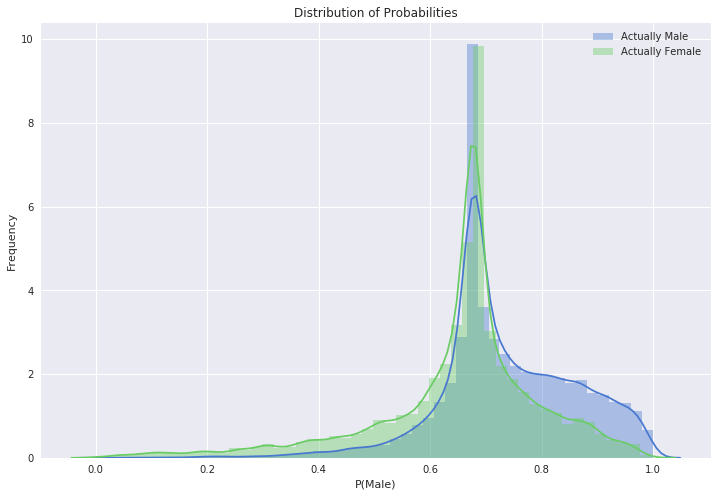

In [49]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='darkgrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1,1, figsize=(12,8))
sns.distplot(error_analysis[error_analysis['actual']==1]['prob'],label='Actually Male')
sns.distplot(error_analysis[error_analysis['actual']==0]['prob'],label='Actually Female')
plt.xlabel("P(Male)")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilities")
plt.legend()
plt.plot()

In [42]:
linelengths=train.linelength.values.reshape(-1,1)
linelengths_test = test.linelength.values.reshape(-1,1)


print 'Logistic Regression on Line Size'
lg = LogisticRegression()
lg.fit(linelengths, labels)
lg_pred = lg.predict(linelengths_test)
print 'Weighted F1 Score:'
print metrics.f1_score(lg_pred,labels_test,average='weighted')
print 'Accuracy'
print metrics.accuracy_score(lg_pred,labels_test)
print 'Confusion Matrix'
print confusion_matrix(labels_test,lg_pred)
print '-----------------------'

Logistic Regression on Line Size


/home/michelle_m_kim/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Weighted F1 Score:
0.825485899195
Accuracy
0.702831833717
Confusion Matrix
[[    0  8521]
 [    0 20153]]
-----------------------


/home/michelle_m_kim/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [43]:
#baseline models

train_lines = train.Line.values
test_lines = test.Line.values

v = TfidfVectorizer()

v_train=v.fit_transform(train_lines)
vocab_train=v.vocabulary_
v_test = v.transform(test_lines)

print "vocab size (all)", len(v.vocabulary_)

print 'Logistic Regression on Lines'
lg = LogisticRegression()
lg.fit(v_train, train_y.values.reshape(-1,1))
print 'Weighted F1 Score:'
print metrics.f1_score(lg.predict(v_test),test_y.values.reshape(-1,1),average='weighted')
print 'Accuracy'
print metrics.accuracy_score(lg.predict(v_test),test_y.values.reshape(-1,1))
print confusion_matrix(test_y.values.reshape(-1,1),lg.predict(v_test))


print '-----------------------'

features = list()
#words that are mostly male
max_weights = list(np.argpartition(lg.coef_[0],-15))[-15:]
for w in max_weights:
    features.append(w)
#words that are mostly female
min_weights = list(np.argpartition(lg.coef_[0],15))[:15]
for m in min_weights:
    features.append(m)

#Make a table with these features and weights
table={}
for f in features:
    weights=list()
    weights.append(round(lg.coef_[0][f],3))
    table[str(v.get_feature_names()[f])]=weights



#Print the table
print 'Word Weights (Negative = More Female, Positive = More Male)'

print "{:<15} {:<30}".format('Feature', 'Male')
for key in sorted(table, key=table.get):
    print "{:<15} {:<30}".format(key, table[key][0])



print '-----------------------'

vocab size (all) 52276
Logistic Regression on Lines
Weighted F1 Score:
0.788490077303
Accuracy
0.71514263793
[[ 1053  7468]
 [  700 19453]]
-----------------------
Word Weights (Negative = More Female, Positive = More Male)
Feature         Male                          
herself         -3.99                         
aibileen        -3.858                        
hilly           -3.821                        
annabelle       -3.622                        
minny           -3.238                        
willoughby      -3.207                        
bartholomew     -2.963                        
skeeter         -2.853                        
evey            -2.758                        
sandro          -2.721                        
derek           -2.667                        
leopold         -2.621                        
evan            -2.553                        
brad            -2.551                        
suzette         -2.549                        
bro             2.255   

In [44]:
towhom=train.drop(['Char','Title','Genre','pkey','LineID','Speech','Line','linelength','M'],1)
towhom_test=test.drop(['Char','Title','Genre','pkey','LineID','Speech','Line','linelength','M'],1)

print towhom.head()

print 'Logistic Regression on To Whom (Male/Female)'
lg = LogisticRegression()
lg.fit(towhom, labels)
lg_pred = lg.predict(towhom_test)
print 'Weighted F1 Score:'
print metrics.f1_score(lg_pred,labels_test,average='weighted')
print 'Accuracy'
print metrics.accuracy_score(lg_pred,labels_test)
print 'Confusion Matrix'
print confusion_matrix(labels_test,lg_pred)
print '-----------------------'

        ToMale  ToFemale
8265         0         1
87408        1         0
134065       0         0
27134        1         0
94155        0         1
Logistic Regression on To Whom (Male/Female)
Weighted F1 Score:
0.825485899195
Accuracy
0.702831833717
Confusion Matrix
[[    0  8521]
 [    0 20153]]
-----------------------


[]

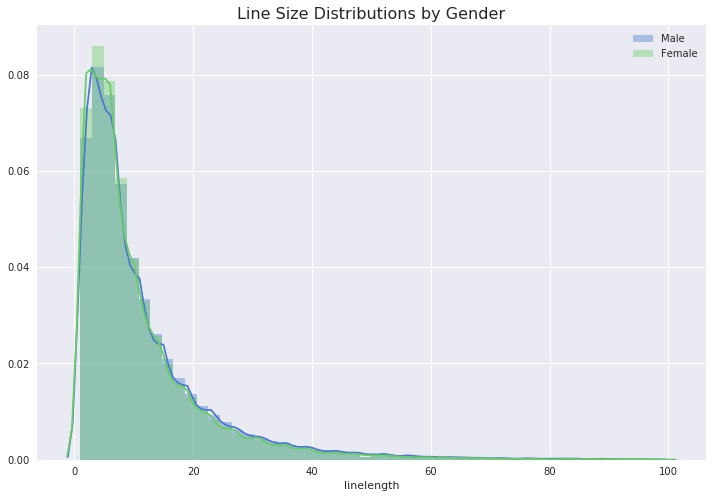

In [70]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='darkgrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1,1, figsize=(12,8))
plt.title("Line Size Distributions by Gender",fontsize=16)
not_long = train[train['linelength']<100]
sns.distplot(not_long[not_long['M']==1]['linelength'],label='Male')
sns.distplot(not_long[not_long['M']==0]['linelength'],label='Female')
#plt.setp(axes, yticks=a)
plt.legend()
plt.plot()

In [68]:
lengths = train.drop(['Char','Title','Genre','pkey','LineID','Speech','M','ToMale','ToFemale'],1)
print len(lengths)
lengths.groupby(['linelength']).count()

258064


Line
linelength       
1           15942
2           18679
3           20076
4           21742
5           20160
6           18480
7           15819
8           13274
9           11299
10           9811
11           8738
12           8074
13           6966
14           6136
15           5562
16           4823
17           4420
18           3983
19           3607
20           3194
21           2874
22           2686
23           2369
24           2165
25           1997
26           1820
27           1545
28           1447
29           1386
30           1261
...           ...
274             2
275             1
279             1
284             1
287             2
289             1
311             1
313             1
320             1
321             1
328             1
329             1
333             1
334             1
335             1
344             1
362             1
363             1
373             1
376             1
378             1
415             1
435             1
463             1
483             1
514             1
538             1
669             1
829             1
1227            1

[265 rows x 1 columns]